## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [56]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from pprint import pprint

In [57]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file
f = open("/content/complaints-2021-05-14_08_16.json")# Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
#Assign new column names
df.rename(columns={'_source.complaint_what_happened':'complaint_what_happened', '_source.product':'tag'}, inplace=True)

In [6]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].isnull().sum()
df['complaint_what_happened'].replace('', np.nan, inplace=True)

In [7]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'],inplace=True)

In [8]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [54]:
# Write your function here to clean the text and remove all the unnecessary elements.
from nltk import pos_tag
def clean_text(text):
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in word_tokenize(text)]
    return lemmatized_tokens

def filter_pos_tags(tokens):
    tagged_tokens = pos_tag(tokens)
    filtered_tokens = [token[0] for token in tagged_tokens if token[1] == 'NN']
    return filtered_tokens


In [58]:
#Write your function to Lemmatize the texts

sentence =''
sent = []
lem_sentence =''
lem_sent =[]
for i in df['complaint_what_happened']:
    clean_sentence = clean_text(i)
    lemmatized_sentence = lemmatize_text(clean_sentence)
    lem_sentence = ' '.join(lemmatized_sentence)
    lem_sent.append(lem_sentence)
    filtered_tokens = filter_pos_tags(lemmatized_sentence)

    sentences = ' '.join(filtered_tokens)
    sent.append(sentences)


In [98]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame({'Original Complaints':df['complaint_what_happened'],'Lemmatized Complaints':lem_sent, 'Complaints_POS_removed':sent})
df_clean.head()

,Original Complaints,Lemmatized Complaints,Complaints_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...


In [99]:
df_clean.shape

(21072, 3)

In [100]:
df_clean

,Original Complaints,Lemmatized Complaints,Complaints_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...
...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...


In [101]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,Original Complaints,Lemmatized Complaints,Complaints_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [102]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length'] = df_clean['Original Complaints'].str.len()
df_clean['complaint_what_happened_lemmatized_length'] = df_clean['Lemmatized Complaints'].str.len()
df_clean['complaint_POS_removed_length'] = df_clean['Complaints_POS_removed'].str.len()
df_clean.head()

,Original Complaints,Lemmatized Complaints,Complaints_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,467,153
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,355,330,103
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,224,207,70
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1502,1412,434
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,449,170


In [103]:
df_clean

,Original Complaints,Lemmatized Complaints,Complaints_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,467,153
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,355,330,103
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,224,207,70
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1502,1412,434
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,449,170
...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,679,619,234
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...,2114,2028,682
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...,2319,2260,707
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...,2171,1937,510


#### Find the top 40 words by frequency among all the articles after processing the text.

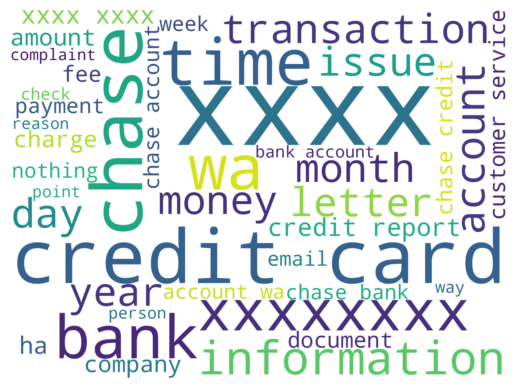

In [104]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud,STOPWORDS
wordcloud=WordCloud(stopwords=STOPWORDS, background_color='white', width=2000, height=1500,max_words=40).generate(' '.join(df_clean['Complaints_POS_removed']))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.show()

In [105]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['Complaints_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [106]:
# function to get the specified top n-grams
def get_top_n_words(corpus, n=None,count=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]

In [107]:
#Print the top 10 words in the unigram frequency
unigram = get_top_n_words(df_clean['Complaint_clean'], 1,10)
for word, freq in unigram:
    print(word, freq)
px.bar(x=[word for word, freq in unigram], y=[freq for word, freq in unigram], title='Top 10 Unigrams')


chase 51080
account 47647
xxxx 38371
credit 33094
wa 32998
card 29587
bank 28233
payment 21167
time 16038
day 12972


In [108]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
bigram = get_top_n_words(df_clean['Complaint_clean'], 2,30)
for word, freq in bigram:
    print(word, freq)
px.bar(x=[word for word, freq in bigram], y=[freq for word, freq in bigram], title='Top 30 Bigrams')


credit card 12824
xxxx xxxx 4098
credit report 3876
customer service 3085
chase credit 3082
chase account 2945
account wa 2849
chase bank 2821
bank account 2809
account chase 2762
account account 2296
checking account 1664
phone call 1631
credit score 1628
account bank 1617
card account 1603
card wa 1601
debit card 1560
wa account 1527
xxxx chase 1516
chase ha 1506
wa chase 1484
account xxxx 1412
card chase 1401
account credit 1394
credit bureau 1297
interest rate 1295
money account 1287
payment wa 1281
wa xxxx 1268


In [109]:
#Print the top 10 words in the bigram frequency

bigram = get_top_n_words(df_clean['Complaint_clean'], 2,10)
for word, freq in bigram:
    print(word, freq)
px.bar(x=[word for word, freq in bigram], y=[freq for word, freq in bigram], title='Top 10 Bigrams')

credit card 12824
xxxx xxxx 4098
credit report 3876
customer service 3085
chase credit 3082
chase account 2945
account wa 2849
chase bank 2821
bank account 2809
account chase 2762


In [110]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
trigram = get_top_n_words(df_clean['Complaint_clean'], 3,30)
for word, freq in trigram:
    print(word, freq)
px.bar(x=[word for word, freq in trigram], y=[freq for word, freq in trigram], title='Top 30 Trigram')


chase credit card 2116
credit card account 1049
credit card company 987
credit card chase 682
inquiry credit report 516
credit card credit 475
xxxx xxxx xxxx 421
account credit card 405
credit reporting agency 388
bank credit card 383
card credit card 358
xxxx credit card 357
credit card bank 355
credit report credit 350
charge credit card 344
credit card wa 338
credit reporting act 329
account credit report 307
chase customer service 296
credit card payment 284
customer service representative 282
credit card xxxx 282
account chase account 271
wa credit card 253
credit card balance 252
victim identity theft 247
consumer protection bureau 245
chase fraud department 244
credit card card 242
chase bank account 239


In [111]:
#Print the top 10 words in the trigram frequency
trigram = get_top_n_words(df_clean['Complaint_clean'], 3,10)
for word, freq in trigram:
    print(word, freq)
px.bar(x=[word for word, freq in trigram], y=[freq for word, freq in trigram], title='Top 10 Trigram')


chase credit card 2116
credit card account 1049
credit card company 987
credit card chase 682
inquiry credit report 516
credit card credit 475
xxxx xxxx xxxx 421
account credit card 405
credit reporting agency 388
bank credit card 383


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [112]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [113]:
#All masked texts has been removed
print(df_clean.shape)
df_clean.head()

(21072, 7)


,Original Complaints,Lemmatized Complaints,Complaints_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,467,153,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,355,330,103,i card agent upgrade date agent wa information...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,224,207,70,card wa application identity consent service c...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1502,1412,434,book ticket i offer ticket card i information...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,449,170,son deposit chase account fund chase bank acco...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [114]:
#Write your code here to initialise the TfidfVectorizer
tf_idf_vec=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [115]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf=tf_idf_vec.fit_transform(df_clean['Complaints_POS_removed'])


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [116]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [117]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [118]:
nmf_model.fit_transform(tfidf)
len(tf_idf_vec.get_feature_names_out())

7073

In [119]:
words = np.array(tf_idf_vec.get_feature_names_out())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,fund,chase,wa,deposit,xxxx,branch,day,checking,business,number,fee
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,bureau,debt,balance,application,year,information
Topic 3,loan,mortgage,xxxx,home,modification,chase,property,year,rate,wa,letter,bank,document,time,foreclosure
Topic 4,charge,card,chase,xxxx,transaction,wa,dispute,fraud,claim,merchant,xxxxxxxx,purchase,service,fee,time
Topic 5,payment,balance,fee,month,statement,wa,xxxxxxxx,day,time,date,chase,auto,xxxx,credit,year


In [120]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_values = nmf_model.transform(tfidf)
topic_values.argmax(axis=1)

array([0, 3, 1, ..., 3, 4, 4])

In [151]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_values.argmax(axis=1) #write your code to assign topics to each rows.

In [152]:
df_clean

,Original Complaints,Lemmatized Complaints,Complaints_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,467,153,morning name stop bank cardmember service debt...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,355,330,103,i card agent upgrade date agent wa information...,3
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,224,207,70,card wa application identity consent service c...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1502,1412,434,book ticket i offer ticket card i information...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,449,170,son deposit chase account fund chase bank acco...,0
...,...,...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,679,619,234,chase card customer decade wa solicitation cre...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...,2114,2028,682,i chas visa credit card provider claim purcha...,3
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...,2319,2260,707,i pay risk consumer i bank app chase year mobi...,3
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...,2171,1937,510,i credit credit card chase freedom problem ba...,4


In [153]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')


,Original Complaints,Lemmatized Complaints,Complaints_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,467,153,morning name stop bank cardmember service debt...,0
28108,I called in today to Chase about something on ...,i called in today to chase about something on ...,i today something cc rep account wa letter acc...,347,332,65,i today something cc rep account wa letter acc...,0
28094,My husband and I bought our vehicle from XXXX ...,my husband and i bought our vehicle from xxxx ...,husband vehicle xxxx xxxxxxxx wa auto bank xxx...,4132,3890,1115,husband vehicle wa auto bank i day amount l...,0
28093,"Hello, I seek help with the Consumer Financial...",hello i seek help with the consumer financial ...,hello i help consumer protection bureau activi...,4500,4318,1341,hello i help consumer protection bureau activi...,0
28090,I opened a new Chase Checking + Savings on XX/...,i opened a new chase checking saving on by usi...,i chase promotion code xxxxxxxxby term service...,526,467,144,i chase promotion code by term service i websi...,0
...,...,...,...,...,...,...,...,...
47617,"Regarding my XXXX Chase Credit Card, Earlier t...",regarding my xxxx chase credit card earlier th...,chase credit card year balance credit card cha...,2107,1692,780,chase credit card year balance credit card cha...,4
47622,I have tried to make my payment with Chase sev...,i have tried to make my payment with chase sev...,payment time payment blue i i past card nobody...,522,501,157,payment time payment blue i i past card nobody...,4
47627,My Chase account has been active since XX/XX/X...,my chase account ha been active since xxxxxxxx...,chase account xxxxxxxx problem account chase s...,1605,1498,518,chase account problem account chase standing ...,4
4606,"Hello, I set up my account for auto debit and ...",hello i set up my account for auto debit and i...,hello i account auto debit reason auto debit w...,761,678,238,hello i account auto debit reason auto debit w...,4


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [154]:
# Create the dictionary of Topic names and Topics
Topic_names = {
    0:'Bank Account services',
    1:'Others',
    2:'Mortgage/Loan',
    3:'Credit card or prepaid card',
    4:'Theft/Dispute Reporting'
  }

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [175]:
print(df_clean.shape)
df_clean.head()


(21072, 8)


,Original Complaints,Lemmatized Complaints,Complaints_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,467,153,morning name stop bank cardmember service debt...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,355,330,103,i card agent upgrade date agent wa information...,3
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,224,207,70,card wa application identity consent service c...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1502,1412,434,book ticket i offer ticket card i information...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,449,170,son deposit chase account fund chase bank acco...,0


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [156]:
Topic_names = {
    'Bank Account services':0,
    'Others':1,
    'Mortgage/Loan':2,
    'Credit card or prepaid card':3,
    'Theft/Dispute Reporting':4
  }
# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)


In [157]:
df_clean

,Original Complaints,Lemmatized Complaints,Complaints_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,467,153,morning name stop bank cardmember service debt...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,355,330,103,i card agent upgrade date agent wa information...,3
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,224,207,70,card wa application identity consent service c...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1502,1412,434,book ticket i offer ticket card i information...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,449,170,son deposit chase account fund chase bank acco...,0
...,...,...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,679,619,234,chase card customer decade wa solicitation cre...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...,2114,2028,682,i chas visa credit card provider claim purcha...,3
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...,2319,2260,707,i pay risk consumer i bank app chase year mobi...,3
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...,2171,1937,510,i credit credit card chase freedom problem ba...,4


In [158]:
df_clean.shape

(21072, 8)

In [159]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['Original Complaints','Topic']]

In [160]:
training_data

,Original Complaints,Topic
1,Good morning my name is XXXX XXXX and I apprec...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,3
10,Chase Card was reported on XX/XX/2019. However...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",1
14,my grand son give me check for {$1600.00} i de...,0
...,...,...
78303,After being a Chase Card customer for well ove...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",3
78310,I am not familiar with XXXX pay and did not un...,3
78311,I have had flawless credit for 30 yrs. I've ha...,4


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [161]:
# Write your code to get the Vector count
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['Original Complaints'])

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [162]:
df_clean

,Original Complaints,Lemmatized Complaints,Complaints_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,467,153,morning name stop bank cardmember service debt...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,355,330,103,i card agent upgrade date agent wa information...,3
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,224,207,70,card wa application identity consent service c...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1502,1412,434,book ticket i offer ticket card i information...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,449,170,son deposit chase account fund chase bank acco...,0
...,...,...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,679,619,234,chase card customer decade wa solicitation cre...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...,2114,2028,682,i chas visa credit card provider claim purcha...,3
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...,2319,2260,707,i pay risk consumer i bank app chase year mobi...,3
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...,2171,1937,510,i credit credit card chase freedom problem ba...,4


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [163]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report




# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

In [164]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1023
           1       0.93      0.93      0.93       952
           2       0.96      0.93      0.94       700
           3       0.90      0.93      0.91      1082
           4       0.96      0.87      0.91       458

    accuracy                           0.93      4215
   macro avg       0.93      0.92      0.93      4215
weighted avg       0.93      0.93      0.93      4215



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [165]:
dt = DecisionTreeClassifier().fit(X_train, y_train)
dt_predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1023
           1       0.93      0.93      0.93       952
           2       0.96      0.93      0.94       700
           3       0.90      0.93      0.91      1082
           4       0.96      0.87      0.91       458

    accuracy                           0.93      4215
   macro avg       0.93      0.92      0.93      4215
weighted avg       0.93      0.93      0.93      4215



In [166]:
dt_d7 = DecisionTreeClassifier(max_depth = 7).fit(X_train, y_train)
dt_predicted_d7 = dt_d7.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1023
           1       0.93      0.93      0.93       952
           2       0.96      0.93      0.94       700
           3       0.90      0.93      0.91      1082
           4       0.96      0.87      0.91       458

    accuracy                           0.93      4215
   macro avg       0.93      0.92      0.93      4215
weighted avg       0.93      0.93      0.93      4215



In [167]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1023
           1       0.68      0.76      0.72       952
           2       0.87      0.74      0.80       700
           3       0.66      0.83      0.73      1082
           4       1.00      0.04      0.08       458

    accuracy                           0.72      4215
   macro avg       0.79      0.65      0.63      4215
weighted avg       0.76      0.72      0.69      4215



In [168]:
nb = GaussianNB().fit(X_train.toarray(), y_train)
predicted = nb.predict(X_test.toarray())

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.39      0.25      0.31      1023
           1       0.36      0.29      0.33       952
           2       0.48      0.47      0.48       700
           3       0.48      0.33      0.39      1082
           4       0.15      0.46      0.23       458

    accuracy                           0.34      4215
   macro avg       0.37      0.36      0.35      4215
weighted avg       0.40      0.34      0.35      4215



In [174]:
print("Accuracy of Logistic Regression: 93%")
print("Accuracy of Decision Tree: 93%")
print("Accuracy of Random Forest: 72%")
print("Accuracy of Naive bayes: 34%")

Accuracy of Logistic Regression: 93%
Accuracy of Decision Tree: 93%
Accuracy of Random Forest: 72%
Accuracy of Naive bayes: 34%
